<a href="https://colab.research.google.com/github/abchiii/RBA_Cash_Rate_Prediction_with_Machine_Learning_Analysis/blob/main/RBA_Cash_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting RBA Monetary Policy Decisions with Hybrid Machine Learning Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import patsy
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.graphics.mosaicplot import mosaic
import graphviz
from sklearn.tree import export_graphviz
from sklearn import set_config
set_config(display='text')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Table of Contents

1. Introduction and Data Collection
2. Model 1: Multinomial Logistic (Interaction 1)
3. Model 2: Multinomial Logistic (Interaction 2)
4. Model 3: Random Forest
5. Model 4: Decision Tree
6. Model 5: XGBoost
7. Comparison and Conclusion

# 1. Introduction and Data Collection

Monetary policy, specifically the cash rate setting by the RBA, plays a critical role in influencing economic activity, inflation and financial stability. Hence, making reliable forecasts of the cash rate is imperative for policymakers, financial institutions and investors to make informed decisions about investments, lending and economic planning. This empirical report aims to explore the effectiveness of parametric and non-parametric predictive models in forecasting the cash rate using data on both domestic and international macroeconomic indicators alongside movements in global financial markets.  

We selected 26 variables based on previous literature (Vasnev et al., 2011) that influence Australian interest rates. These variables fall into three categories:  

-	Macroeconomic performance:  
Unemployment Rate,
Commodity Prices,
Monthly Hours Worked,
Premixed Concrete Production,
Annual Growth in CPI,
Real Labor Cost,
Manufacturing Production,
Domestic Final Demand,
Fixed Capital Formation(private sector),
Growth in Real GDP,
Household Consumption,
Inflation Expectation


-	Global influences:  
Total Imports,
Total Exports,
US Exchange Rate,
JP Exchange Rate,
Growth in US Real GDP,
Growth in JP Real GDP,
Growth in CN Real GDP

-	Financial activity:  
Annual Growth in M3,
Growth in S&P500,
Growth in NIKKEI,
Growth in HSI,
Growth in DAX,
Growth in FTSE,
Business Credit

We harmonized monthly and quarterly data by forward-filing the quarterly values, also since we only have quarterly data up to 2023 Q2, we then backward-filled the data for two periods. To avoid multicollinearity, we transformed the continuous cash rate into a categorical variable (-1, 0, 1) representing rate decreases, holds, and increases. We also standardized the data to mean 0 and variance 1 for multinomial regressions and random forests.

As past values are critical in RBA decision-making, we decided to include 3 lags with discretion for model simplification, denoted with ’ for 1st lag,’’ for 2nd lag, ’’’ for 3rd lag. Our final data set contains 79 variables each with 292 observations.


In [ ]:
df = pd.read_excel('RBA_Macro_Data.xlsx')

# 2. Model 1: Multinomial Logistic (Interaction 1)

**A. Model Creation and Training of Multinomial Logistic with Interaction 1**


**(1) Select the optimal regularisation parameter (C)**  

Two method were used:  
(i) built-in LogisticRegressionCV to maximise accuracy, and   
(ii) manual loop to prioritise precise probability estimates by minimising Deviance (Log Loss)  



**(i) Built-in LogisticRegressionCV to maximise accuracy**

In [ ]:
y = df['Y'][:-1]  # Exclude the last row of the target variable (The Prediction Row)
x = df.iloc[:-1, 2:]  # Exclude the last row from the feature set (and also exclude the ID columns)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Training data (80%)
X_test = scaler.transform(X_test)  # Testing data (20%)

# Logistic regression with cross-validation for alpha (regularization strength)
alphas = np.logspace(-6, 3, 100)
model = LogisticRegressionCV(
    Cs=alphas,
    cv=5,
    penalty='l1',
    solver='saga',
    max_iter=10000,
)

# Fit the model
model.fit(X_train, y_train)

best_C = model.C_[0]  # C is the inverse of alpha
print(f"Best C: {best_C}")

Best C: 0.1


**(ii) Manual loop to prioritise precise probability estimates by minimising Deviance (Log Loss)**

In [ ]:
# Store the mean and variance for the deviance
deviance_mean = []
deviance_std = []

# CV and calculate the deviance
Cs = np.logspace(-6, 3, 100)
for C in Cs:
    lasso_logreg = LogisticRegression(solver='saga', penalty='l1', max_iter=10000, C=C)
    cv_scores = cross_val_score(lasso_logreg, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    deviance_mean.append(-2 * cv_scores.mean())   # deviance = -2 * log-likelihood
    deviance_std.append(cv_scores.std() * 2)

# Put the result in dataframe
cv_results = pd.DataFrame({'C': Cs,
                           'negative deviance': deviance_mean,
                           'std_error': deviance_std})

In [ ]:
# Choose the best C
best_index = np.argmin(cv_results['negative deviance'])
best_C = cv_results['C'][best_index]
print(f"Best C: {best_C}")

Best C: 0.1519911082952933


In [ ]:
# Plot Lasso Cross-Validation Results across C values
fig = px.line(cv_results, x='C', y='negative deviance')
fig.update_layout(title='Lasso Cross-Validation Results',
                  xaxis_title='C',
                  xaxis_type='log',
                  yaxis_title='Deviance')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))

# Print the Plot
fig.show()

**Decision of Optimal Regularisation Parameter (C)**

The analysis demonstrates that both the *accuracy-driven method (C=0.1)* and the *deviance-driven method (C≈0.152)* converge on the same optimal region, validating the model's robustness. The graph above visually confirms this "sweet spot" at the curve's trough, where the deviance is minimized. Consequently, choosing **C≈0.152** is the most scientifically sound decision, as it mathematically minimises the probability error essential for risk modeling while remaining firmly within the stable zone of the bias-variance tradeoff.

**(2) Hybrid Feature Selection with Interaction Refinement (Lasso and Random Forest)**  

**The steps to select important features:**
1.   **Initial Screening:** Applied Lasso to identify key linear drivers.
2.   **Non-Linearity Check:** Used Random Forest importance rankings to recover significant non-linear features potentially suppressed by Lasso.
3.  **Interaction Check:** Generated 2-way and 3-way interactions between the top two Random Forest features and the Lasso-selected baseline.
4.   **Final Refinement:** Executed sequential Lasso CV models on the expanded set to isolate significant interaction effects and remove multicollinearity.


In [ ]:
# Select the features
selected_features = np.where(np.any(model.coef_ != 0, axis=0))[0]
X_train_selected = X_train[:, selected_features]

# Print selected features
selected_feature_names = [x.columns[i] for i in selected_features]
print("Selected Features by Lasso (C=0.1519911082952933):")
for feature in selected_feature_names:
    print(feature)

Selected Features by Lasso (C=0.1519911082952933):
Y'
Y''
Y'''
Unemployment Rate'
JP Exchange Rate'
Annual Growth in M3'
Growth in S&P500''
Growth in S&P500'''
Growth in NIKKEI''
Growth in FTSE'''
Annual Growth in CPI''
Inflation Expectation'
Inflation Expectation''
Inflation Expectation'''


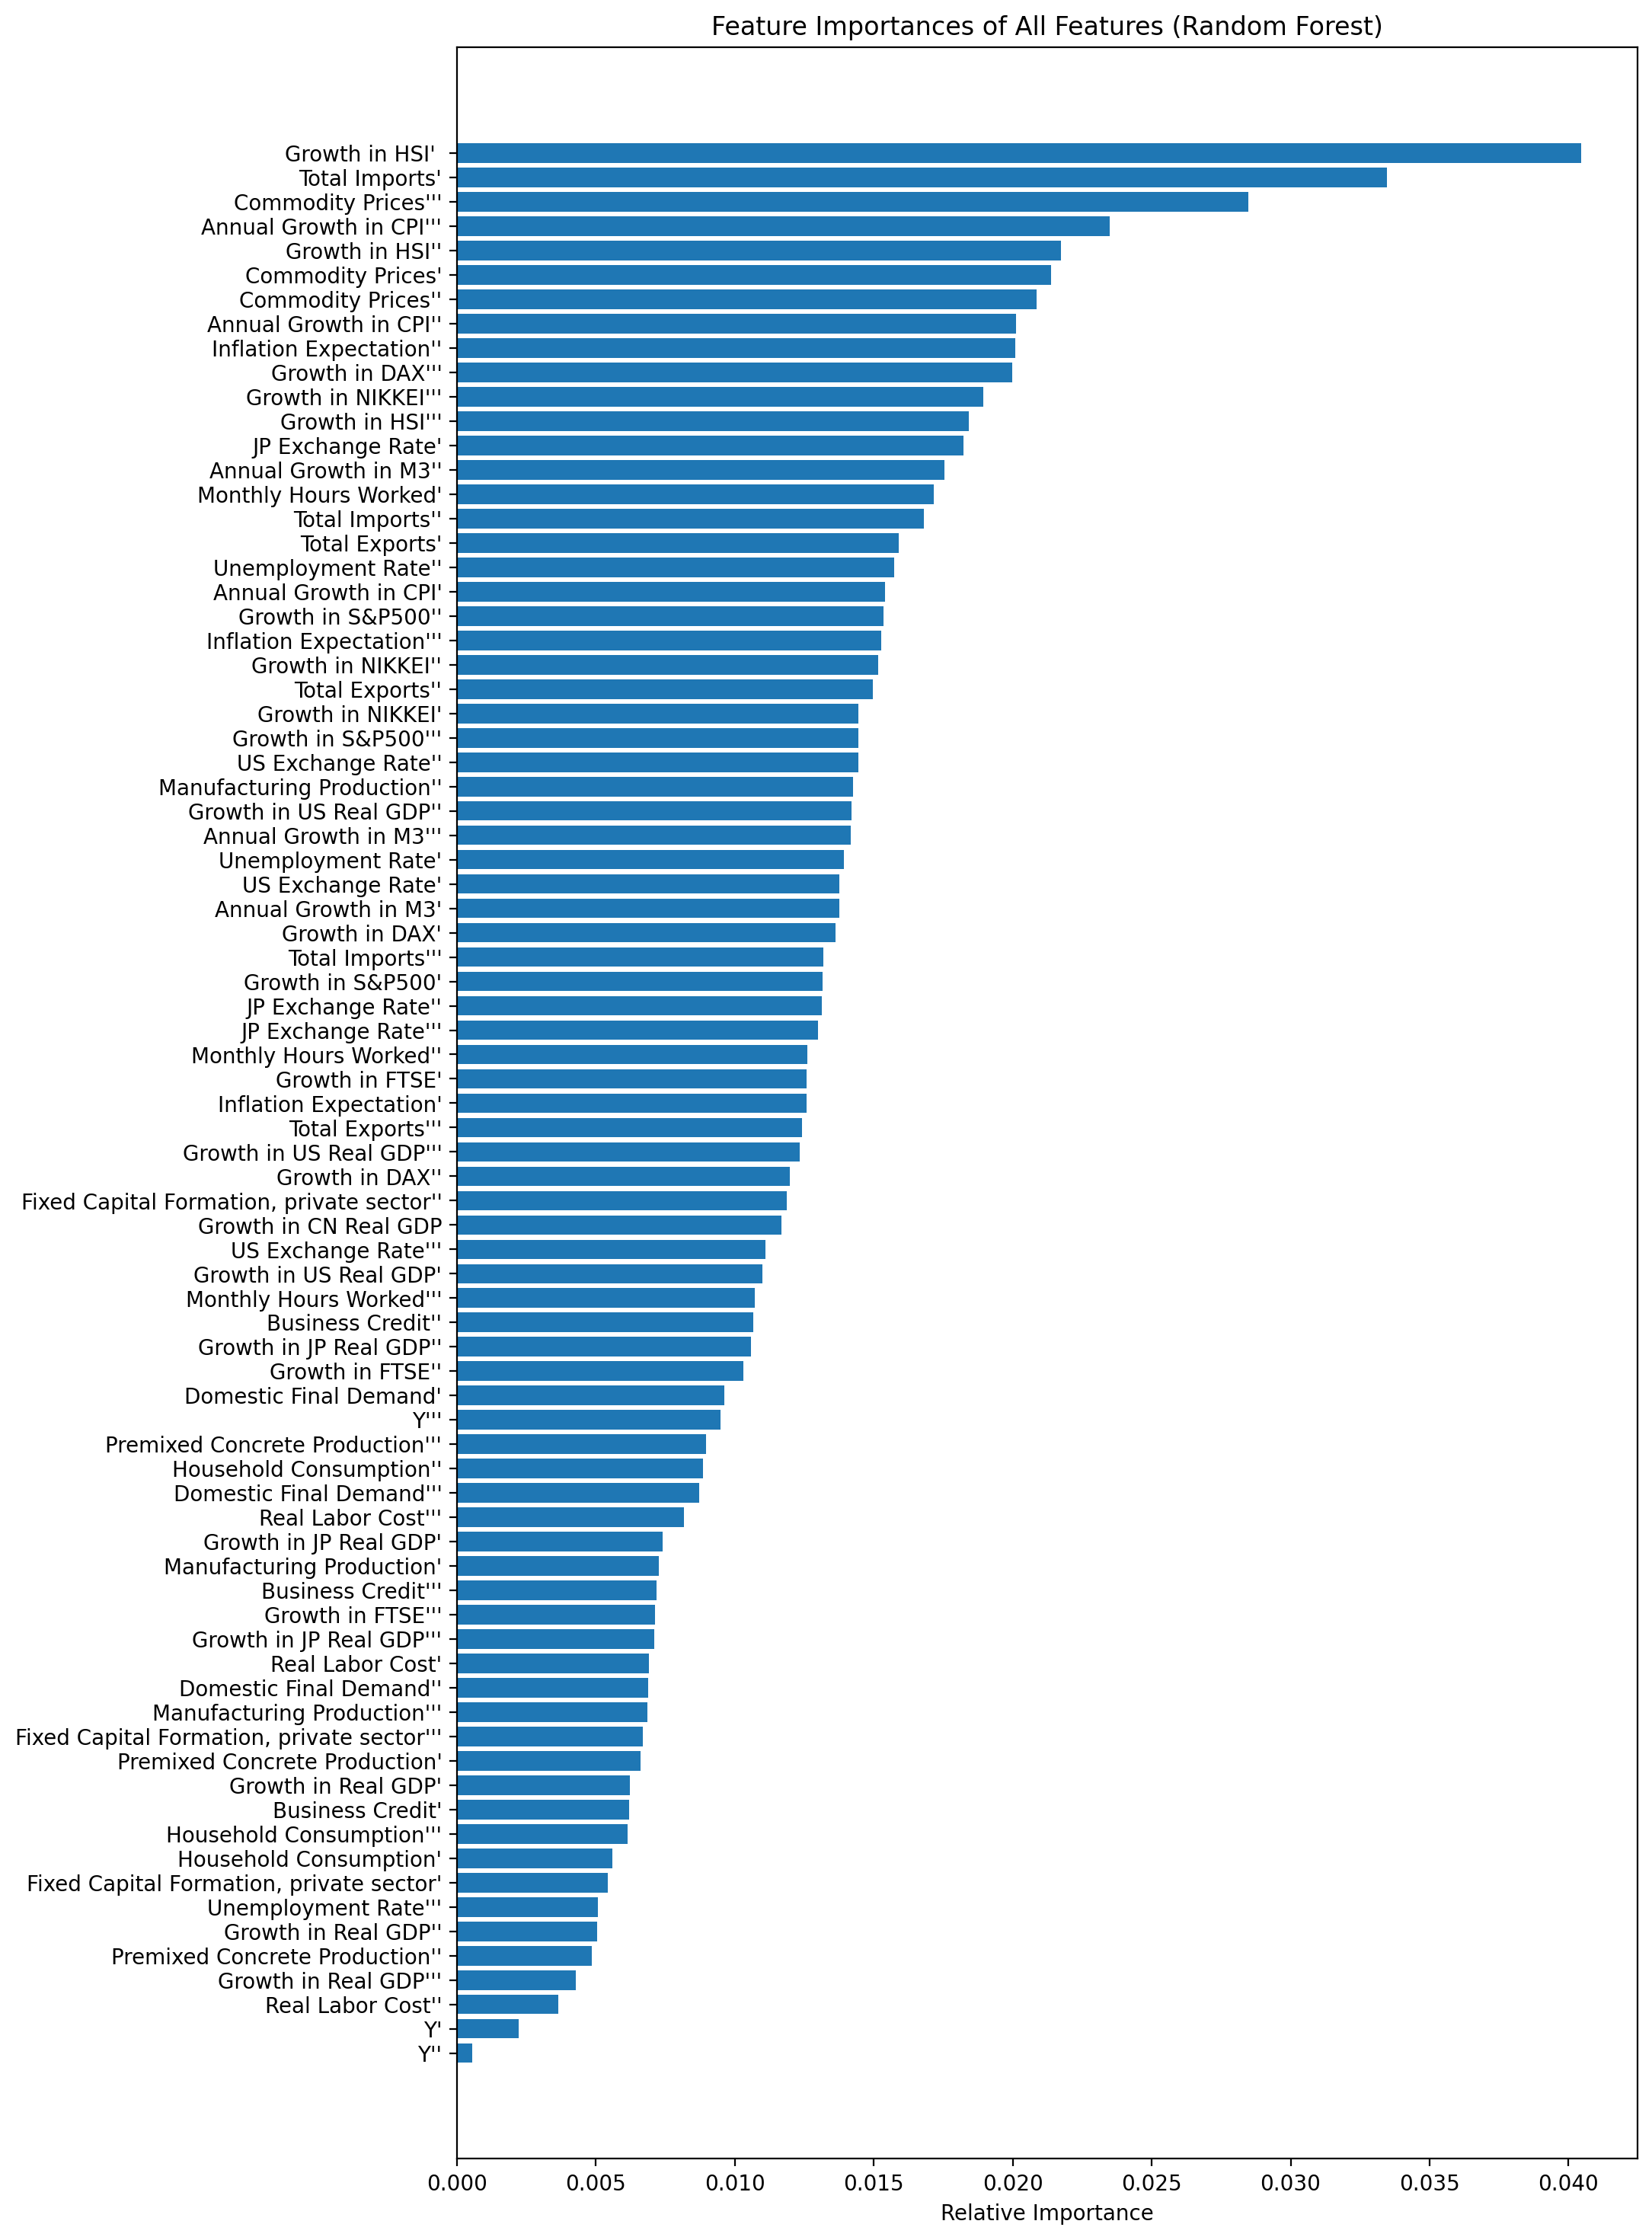

In [ ]:
# Train the random forest by X_train and y_train
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Sort the importance of each feature by random forest
importances = clf.feature_importances_
indices = np.argsort(importances)

# Bar chart for importance ranking
plt.figure(figsize=(10, 18), dpi=200)
plt.title('Feature Importances of All Features (Random Forest)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [x.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Extract V1, V2 and Lasso selected features from the scaled X_train
V1 = X_train[:, x.columns.get_loc("Annual Growth in CPI''")]
V2 = X_train[:, x.columns.get_loc("Inflation Expectation'''")]
X_train_selected = X_train[:, selected_features]

# Create pairwise interaction for V1 and Lasso selected features, V2 and Lasso selected features
interaction_terms_V1 = V1[:, np.newaxis] * X_train_selected
interaction_terms_V2 = V2[:, np.newaxis] * X_train_selected

# Create 3-way interaction: V1 * V2 * selected feature
interaction_terms_V1_V2 = (V1 * V2)[:, np.newaxis] * X_train_selected

# Combine the interactions with Lasso selected features
X_train_new = np.hstack([X_train_selected, interaction_terms_V1, interaction_terms_V2, interaction_terms_V1_V2])

# Multinomial logistic regression with Lasso regularization set using known optimal alpha settings
C =  0.1519911082952933
model = LogisticRegression(
    C=C,
    penalty='l1',
    solver='saga',
    max_iter=10000
)

# Train the model
model.fit(X_train_new, y_train)

# Select the features with coefficient not equal to 0
selected_new_features = np.where(np.any(model.coef_ != 0, axis=0))[0]

# Create lists for Lasso selected features, interaction with V1, interaction with V2, and 3-way interaction
original_feature_names = [x.columns[i] for i in selected_features]
interaction_feature_names_V1 = [f'V1 * {name}' for name in original_feature_names]
interaction_feature_names_V2 = [f'V2 * {name}' for name in original_feature_names]
interaction_feature_names_V1_V2 = [f'V1 * V2 * {name}' for name in original_feature_names]

# Combine all selected features to one list
all_feature_names = original_feature_names + interaction_feature_names_V1 + interaction_feature_names_V2 + interaction_feature_names_V1_V2

# Print all selected features
selected_feature_names = [all_feature_names[i] for i in selected_new_features]
print("Final Selected Features by Lasso with Interactions:")
for feature in selected_feature_names:
    print(feature)

Final Selected Features by Lasso with Interactions:
Y'
Y''
Y'''
JP Exchange Rate'
Annual Growth in M3'
Growth in FTSE'''
V1 * Y'''
V1 * JP Exchange Rate'
V1 * Growth in S&P500'''
V1 * Growth in FTSE'''
V2 * Y''
V2 * Annual Growth in M3'
V1 * V2 * Y'
V1 * V2 * Unemployment Rate'
V1 * V2 * JP Exchange Rate'
V1 * V2 * Growth in S&P500''
V1 * V2 * Growth in S&P500'''
V1 * V2 * Growth in NIKKEI''
V1 * V2 * Inflation Expectation'''


**B. Model Testing of Multinomial Logistic with Interaction 1**

In [ ]:
# Extract test data corresponding to the features selected by V1, V2, and Lasso
V1_test = X_test[:, x.columns.get_loc("Annual Growth in CPI''")]
V2_test = X_test[:, x.columns.get_loc("Inflation Expectation'''")]
X_test_selected = X_test[:, selected_features]

# Create pairwise interation for V1 and Lasso selected features, V2 and Lasso selected features
interaction_terms_V1_test = V1_test[:, np.newaxis] * X_test_selected
interaction_terms_V2_test = V2_test[:, np.newaxis] * X_test_selected

# Create 3-way interaction: V1 * V2 * selected feature
interaction_terms_V1_V2_test = (V1_test * V2_test)[:, np.newaxis] * X_test_selected

# Combine the interactions with Lasso CV selected features
X_test_new = np.hstack([X_test_selected, interaction_terms_V1_test, interaction_terms_V2_test, interaction_terms_V1_V2_test])

# Predict by using the trained model
y_pred_m1 = model.predict(X_test_new)

# Print the prediction result
print("Predicted values for the test set:")
print(y_pred_m1)

# Calculate the accuracy rate
accuracy_m1 = accuracy_score(y_test, y_pred_m1)
print(f"Accuracy: {accuracy_m1:.4f}")

# Create confusion matrix
conf_matrix_m1 = confusion_matrix(y_test, y_pred_m1)
print("Confusion Matrix:")
print(conf_matrix_m1)

# Print the report includin precision, recall, fi-scare, etc
class_report_m1 = classification_report(y_test, y_pred_m1)
print("Classification Report:")
print(class_report_m1)

Predicted values for the test set:
[ 0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0 -1  0  0  0  0  0 -1
  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0]
Accuracy: 0.6780
Confusion Matrix:
[[ 1  7  0]
 [ 1 36  3]
 [ 0  8  3]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.12      0.20         8
           0       0.71      0.90      0.79        40
           1       0.50      0.27      0.35        11

    accuracy                           0.68        59
   macro avg       0.57      0.43      0.45        59
weighted avg       0.64      0.68      0.63        59



**C. Prediction for Multinomial Logistic with Interaction 1**

In [ ]:
# Use the entire dataset, including the last row
X_full = df.iloc[:, 2:]
y_full = df['Y']

# Standardize the full dataset
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# Select the Lasso selected features from the standardized dataset
X_full_selected = X_full_scaled[:, selected_features]

# Create interaction terms using the standardized selected features
V1_full = X_full_scaled[:, x.columns.get_loc("Annual Growth in CPI''")]
V2_full = X_full_scaled[:, x.columns.get_loc("Inflation Expectation'''")]

interaction_terms_V1_full = V1_full[:, np.newaxis] * X_full_selected
interaction_terms_V2_full = V2_full[:, np.newaxis] * X_full_selected
interaction_terms_V1_V2_full = (V1_full * V2_full)[:, np.newaxis] * X_full_selected

# Combine the standardized selected features with the interaction terms
X_full_new = np.hstack([X_full_selected, interaction_terms_V1_full, interaction_terms_V2_full, interaction_terms_V1_V2_full])

# Use the entire dataset for prediction
X_last_row = X_full_new[-1].reshape(1, -1)

# Use the trained model to predict the next period
y_next_pred_m1 = model.predict(X_last_row)

# Output the prediction for the next period
print("Prediction by Multinomial with interaction 1:")
print(y_next_pred_m1)

Prediction by Multinomial with interaction 1:
[0]


# 3. Model 2: Multinomial Logistic with Interaction 2

**A. Model Creation and Training of Multinomial Logistic with Interaction 2**

**Create pairwse interactions among all Lasso CV selected features**

In [ ]:
# Extract the Lasso selected features
X_train_selected = X_train[:, selected_features]

original_feature_names = [x.columns[i] for i in selected_features]

# Create pairwse interactions
interaction_terms = []
interaction_feature_names = []

for (i, j) in itertools.combinations(range(X_train_selected.shape[1]), 2):
    interaction_term = X_train_selected[:, i] * X_train_selected[:, j]
    interaction_terms.append(interaction_term[:, np.newaxis])
    interaction_feature_names.append(f'{original_feature_names[i]} * {original_feature_names[j]}')

interaction_terms = np.hstack(interaction_terms)

# Combine the interaction terms and Lasso selected features
X_train_new = np.hstack([X_train_selected, interaction_terms])

# Multinomial logistic regression with Lasso regularization set using the known optimal alpha
C = 0.1519911082952933
model = LogisticRegression(
    C=C,
    penalty='l1',
    solver='saga',
    max_iter=10000
)

# Train the model
model.fit(X_train_new, y_train)

# Select the features with coefficient not equal to 0
selected_new_features = np.where(np.any(model.coef_ != 0, axis=0))[0]

# Combine all selected features to one list
all_feature_names = original_feature_names + interaction_feature_names

# Print all selected features
selected_feature_names = [all_feature_names[i] for i in selected_new_features]
print("Selected Features after Lasso with Interactions:")
for feature in selected_feature_names:
    print(feature)

Selected Features after Lasso with Interactions:
Y'
Y''
Y'''
Unemployment Rate'
Annual Growth in M3'
Growth in S&P500''
Growth in S&P500'''
Growth in FTSE'''
Inflation Expectation'
Inflation Expectation''
Inflation Expectation'''
Y' * Y'''
Y' * Growth in S&P500''
Y' * Growth in S&P500'''
Y' * Growth in NIKKEI''
Y'' * Y'''
Y'' * JP Exchange Rate'
Y'' * Annual Growth in M3'
Y'' * Growth in FTSE'''
Y'' * Inflation Expectation''
Y''' * Annual Growth in M3'
Y''' * Annual Growth in CPI''
Unemployment Rate' * Annual Growth in M3'
Unemployment Rate' * Annual Growth in CPI''
Unemployment Rate' * Inflation Expectation'''
JP Exchange Rate' * Annual Growth in M3'
JP Exchange Rate' * Growth in NIKKEI''
JP Exchange Rate' * Annual Growth in CPI''
JP Exchange Rate' * Inflation Expectation'''
Annual Growth in M3' * Growth in FTSE'''
Annual Growth in M3' * Inflation Expectation'''
Growth in S&P500'' * Growth in S&P500'''
Growth in S&P500''' * Annual Growth in CPI''
Growth in S&P500''' * Inflation Expect

**B. Model Testing of Multinomial Logistic with Interaction 2**

In [ ]:
# Extract the Lasso selected features from X_test
X_test_selected = X_test[:, selected_features]

# Create pairwise interaction terms among all Lasso CV selected features for the test set
interaction_terms_test = []

for (i, j) in itertools.combinations(range(X_test_selected.shape[1]), 2):
    interaction_term_test = X_test_selected[:, i] * X_test_selected[:, j]
    interaction_terms_test.append(interaction_term_test[:, np.newaxis])

interaction_terms_test = np.hstack(interaction_terms_test)

# Combine the interaction terms and Lasso selected features to create X_test_new for Model 2
X_test_new = np.hstack([X_test_selected, interaction_terms_test])

# Predict by using the trained model
y_pred_m2 = model.predict(X_test_new)

# Print the prediction result
print("Predicted values for the test set:")
print(y_pred_m2)

# Calculate the accuracy rate
accuracy_m2 = accuracy_score(y_test, y_pred_m2)
print(f"Accuracy: {accuracy_m2:.4f}")

# Create confusion matrix
conf_matrix_m2 = confusion_matrix(y_test, y_pred_m2)
print("Confusion Matrix:")
print(conf_matrix_m2)

# Print the report includin precision, recall, fi-scare, etc
class_report_m2 = classification_report(y_test, y_pred_m2)
print("Classification Report:")
print(class_report_m2)

Predicted values for the test set:
[ 0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0 -1
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0]
Accuracy: 0.7119
Confusion Matrix:
[[ 1  7  0]
 [ 0 38  2]
 [ 0  8  3]]
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.12      0.22         8
           0       0.72      0.95      0.82        40
           1       0.60      0.27      0.38        11

    accuracy                           0.71        59
   macro avg       0.77      0.45      0.47        59
weighted avg       0.73      0.71      0.65        59



**C. Prediction by Multinomial Logistic with Interaction**

In [ ]:
# Standardize the full dataset (assuming df is the full dataset and it includes all relevant features)
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(df.iloc[:, 2:])  # Standardize all features from the full dataset (skip ID columns)

# Select the Lasso-selected features from the full standardized dataset
X_full_selected = X_full_scaled[:, selected_features]  # Lasso-selected features from the full dataset

# Create all pairwise interaction terms for the full dataset
interaction_terms_full = []

for (i, j) in itertools.combinations(range(X_full_selected.shape[1]), 2):  # Create pairwise combinations of features
    interaction_term_full = X_full_selected[:, i] * X_full_selected[:, j]  # Compute interaction term
    interaction_terms_full.append(interaction_term_full[:, np.newaxis])  # Add to the list of interaction terms

# Combine the Lasso selected features with the interaction terms for the full dataset
interaction_terms_full = np.hstack(interaction_terms_full)
X_full_new = np.hstack([X_full_selected, interaction_terms_full])

# Predict the next period using the last row of the full dataset
X_last_row = X_full_new[-1].reshape(1, -1)  # Use the last row for prediction

# Use the trained model to predict the next period
y_next_pred_m2 = model.predict(X_last_row)

# Output the prediction for the next period
print("Prediction by Multinomial with interaction 2:")
print(y_next_pred_m2)

Prediction by Multinomial with interaction 2:
[0]


# 4. Model 3: Random Forest

**A. Model Creation and Training of Random Forest**

In [ ]:
# RF without differencing
y = df['Y'][:-1]  # Exclude the last row of the target variable
x = df.iloc[:-1, 2:]  # Exclude the last row from the feature set (and also exclude the ID columns)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# The model builds 100 distinct decision trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**B. Model Testing of Random Forest**

In [ ]:
y_pred_rf = rf.predict(X_test)

# Print the prediction result
print("Predicted values for the test set:")
print(y_pred_rf)

# Calculate the accuracy rate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# Create confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Print the report includin precision, recall, fi-scare, etc
class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(class_report_rf)

Predicted values for the test set:
[ 0  0  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
  1  0  0  0 -1  0  0  0  0  0  0]
Accuracy: 0.7288
Confusion Matrix:
[[ 2  6  0]
 [ 1 38  1]
 [ 0  8  3]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.25      0.36         8
           0       0.73      0.95      0.83        40
           1       0.75      0.27      0.40        11

    accuracy                           0.73        59
   macro avg       0.72      0.49      0.53        59
weighted avg       0.73      0.73      0.68        59



**C. Prediction by Random Forest**

In [ ]:
# Use the last row of the entire standardized dataset for prediction
X_last_row = df.iloc[[-1], 2:]  # Take the last row from the entire dataset

# Predict the next period using the trained random forest model
y_next_pred_rf = rf.predict(X_last_row)

# Output the prediction for the next period
print("Prediction by Random Forest:")
print(y_next_pred_rf)

Prediction by Random Forest:
[0]


# 5. Model 4: Decision Tree

**A. Model Creation and Training of Decision Tree**

In [ ]:
# Prune the Decision Tree
regtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
regtree.fit(X_train, y_train)
path = regtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Aalculate the best alpha
scores = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=alpha, max_depth=5, min_samples_leaf=20)
    score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))  # Using 5-fold CV
    scores.append(score)

best_alpha = ccp_alphas[np.argmax(scores)]
print(f"Best alpha: {best_alpha:.2f}")


Best alpha: 0.00


In [ ]:
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha, max_depth=5, min_samples_leaf=20)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0), max_depth=5,
                       min_samples_leaf=20)

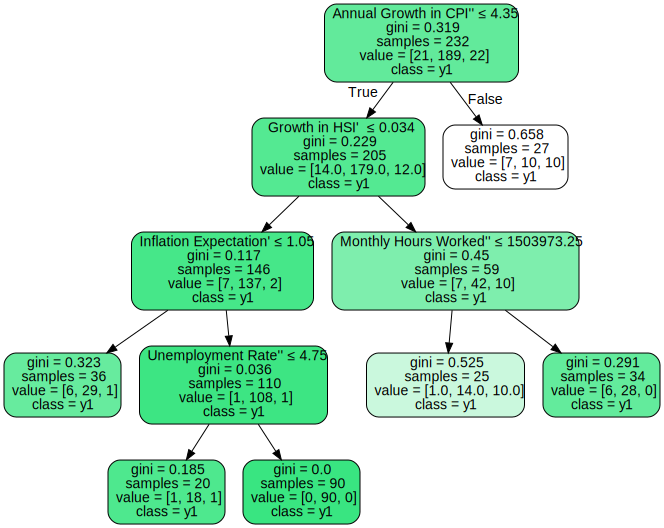

In [ ]:
dot_data = export_graphviz(pruned_tree, out_file=None,
                           feature_names=[name.replace('&', '&amp;') for name in X_train.columns], # Escape '&' with '&amp;'
                           class_names=True, filled=True,
                           rounded=True, special_characters=True)

# Generate the graph from dot data
graph = graphviz.Source(dot_data)
graph

**Notes for Decision Tree Plot**

Class y₁ (cash rate holds, "0") dominates all of the tree’s nodes, meaning that the model overwhelmingly predicts this class. This suggests a potential data bias, where the model is heavily influenced by an imbalance in the data, leading to skewed predictions.

**B. Model Testing of Decision Tree**

In [ ]:
y_pred_dt = pruned_tree.predict(X_test)

# Print the prediction result
print("Predicted values for the test set:")
print(y_pred_dt)

# Calculate the accuracy rate
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt:.4f}")

# Create confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)

# Print the report includin precision, recall, fi-scare, etc
class_report_dt = classification_report(y_test, y_pred_dt, zero_division=0)
print("Classification Report:")
print(class_report_dt)

Predicted values for the test set:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.6780
Confusion Matrix:
[[ 0  8  0]
 [ 0 40  0]
 [ 0 11  0]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.68      1.00      0.81        40
           1       0.00      0.00      0.00        11

    accuracy                           0.68        59
   macro avg       0.23      0.33      0.27        59
weighted avg       0.46      0.68      0.55        59



**C. Prediction for Decision Tree**

In [ ]:
# Use the last row of the entire standardized dataset for prediction
X_last_row = df.iloc[[-1], 2:]

# Predict the next period using the pruned decision tree model
y_next_pred_dt = pruned_tree.predict(X_last_row)

# Output the prediction
print("Prediction by Decision Tree:")
print(y_next_pred_dt)

Prediction by Decision Tree:
[0]


# 6. Model 5: XGBoost

**A. Model Creation and Training of XGBoost**

In [ ]:
# Encode the labels to be in [0, num_classes-1]
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
params = {
    'max_depth': 5,          # Maximum depth of a tree
    'eta': 0.1,              # Learning rate, between 0-1, 0.1 means the model learns slowly to reduce overfitting
    'objective': 'multi:softmax',  # Multiclass classification objective
    'eval_metric': 'mlogloss',     # Evaluation metric for multiclass classification
    'num_class': 3       # Number of classes in the problem
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=10)

**B. Model Testing of XGBoost**

In [ ]:
# Predict on the test set
dtest = xgb.DMatrix(X_test)
y_pred_xg_encoded= bst.predict(dtest)
y_pred_xg = le.inverse_transform(y_pred_xg_encoded.astype(int))

# Print the prediction result
print("Predicted values for the test set:")
print(y_pred_xg)

# Calculate accuracy
accuracy_xg = accuracy_score(y_test, y_pred_xg)
print(f'Accuracy: {accuracy_xg:.4f}')

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xg)
print("Confusion Matrix:")
print(conf_matrix)

# Print the report includin precision, recall, fi-scare, etc
class_report_xg = classification_report(y_test, y_pred_xg, zero_division=0)
print("Classification Report:")
print(class_report_xg)

Predicted values for the test set:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.7119
Confusion Matrix:
[[ 0  8  0]
 [ 0 40  0]
 [ 0  9  2]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         8
           0       0.70      1.00      0.82        40
           1       1.00      0.18      0.31        11

    accuracy                           0.71        59
   macro avg       0.57      0.39      0.38        59
weighted avg       0.66      0.71      0.62        59



**C. Prediction by XGBoost**

In [ ]:
# Use the last row of the full standardized dataset for prediction
X_last_row = df.iloc[[-1], 2:]

# Prepare the last row as a DMatrix for XGBoost and assign feature names
feature_names = df.columns[2:].tolist()  # Convert the Index object to a list of strings
dlast_row = xgb.DMatrix(X_last_row, feature_names=feature_names)

# Predict the next period using the trained XGBoost model
y_next_pred_xg_encoded = bst.predict(dlast_row)
y_next_pred_xg = le.inverse_transform(y_next_pred_xg_encoded.astype(int))  # Decode the predicted labels

# Output the prediction for the next period
print("Prediction by XGBoost model:")
print(y_next_pred_xg)

Prediction by XGBoost model:
[0]


# 7. Comparison and Conclusion
*(Comparison table and Confusion matrices are below)*

Our analysis identifies the **Random Forest** model as the most robust performer, supported by feature selection that confirmed the significant predictive power of macroeconomic and global market indices in capturing RBA policy shifts. However, the confusion matrices reveal a critical **class imbalance where the Hold (0) status dominated historical data**, causing models, particularly Decision Trees and XGBoost, to overly favour this majority outcome. While Multinomial 2 showed the best sensitivity to minority classes, all five models ultimately converged on a unanimous that the cash rate would hold in the nex period.  

We confirmed that macroeconomic indicators and global market indices are strong predictors of the cash rate, effectively surviving LASSO selection and dominating the structure of our tree-based models. These findings imply our models successfully detect the RBA’s policy responses to global economic shifts.

Conversely, the presence of class imbalance notably affected model reliability, leading to potential bias in predictions. This underscores the importance of mindful dataset construction; results should be interpreted with caution, and future work must account for these imbalances to avoid skewed outcomes.

**Comparison Tables and Matrices**

In [ ]:
# Create a dictionary of theresults
results_data = {
    'Model': ['Multinomial 1', 'Multinomial 2', 'Random Forest', 'Decision Tree', 'XGBoost'],
    'Accuracy': [0.68, 0.71, 0.73, 0.68, 0.71],
    'Macro F1': [0.45, 0.67, 0.53, 0.27, 0.38],
    'Weighted F1': [0.63,0.45, 0.68, 0.55, 0.62],
    'Next Period Prediction': [0, 0, 0, 0, 0],
}

#Create the DataFrame
df_comparison = pd.DataFrame(results_data)
df_comparison.set_index('Model', inplace=True)

# 3. Display
display(df_comparison)

,Accuracy,Macro F1,Weighted F1,Next Period Prediction
Model,,,,
Multinomial 1,0.68,0.45,0.63,0
Multinomial 2,0.71,0.67,0.45,0
Random Forest,0.73,0.53,0.68,0
Decision Tree,0.68,0.27,0.55,0
XGBoost,0.71,0.38,0.62,0


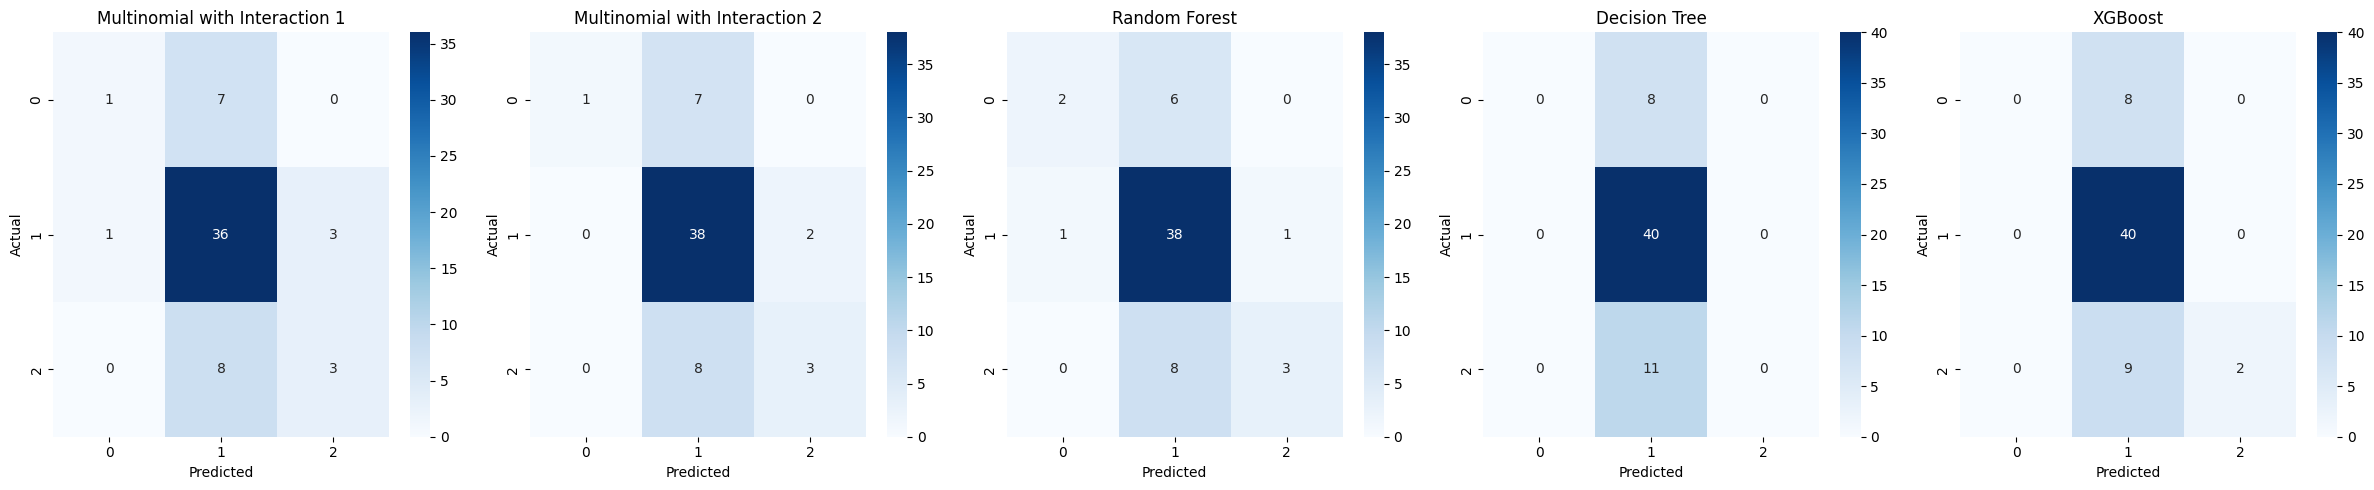

In [ ]:
# List of your models and their predictions
# Format: (Model Name, y_pred_variable)
models = [
    ("Multinomial with Interaction 1", y_pred_m1),
    ("Multinomial with Interaction 2", y_pred_m2),
    ("Random Forest", y_pred_rf),
    ("Decision Tree", y_pred_dt),
    ("XGBoost", y_pred_xg)
]

fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for ax, (name, pred) in zip(axes, models):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()